# Capture Detected Human into Boxes

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import time
%matplotlib inline

sys.path.insert(0,os.path.abspath(".."))
from utils import label_map_util
from utils import visualization_utils as vis_util

# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
# MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'

PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
PATH_TO_TEST_IMAGES_DIR = 'test_images'
IMAGE_SIZE = (12, 30)

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

sample.jpg 12.39696 seconds


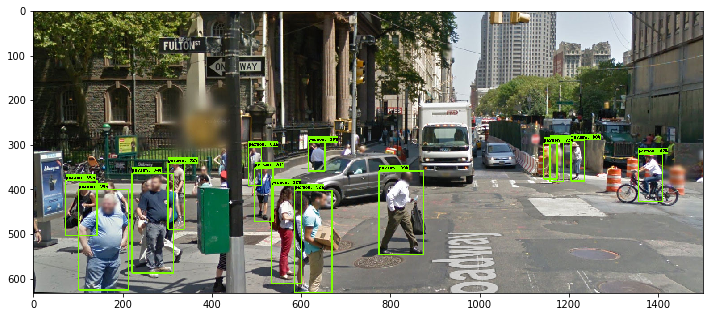

In [2]:
boxes = None
scores = None
classes = None
cropped_image = None
image = None
image_tensor = None

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in  os.listdir(PATH_TO_TEST_IMAGES_DIR):
            start = time.time()
            image = Image.open(os.path.join(PATH_TO_TEST_IMAGES_DIR, image_path))
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            (boxes, scores, classes, num_detections) = sess.run([boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
               
            print(image_path, str(time.time()-start)[:-10],'seconds')
            
            
            
            vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3,
                max_boxes_to_draw=20,
                min_score_thresh=0.7)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

In [31]:
boxes = np.squeeze(boxes)
classes = np.squeeze(classes).astype(np.int32)
scores = np.squeeze(scores)
image_np = load_image_into_numpy_array(image)

In [36]:
tf_image = tf.image.encode_jpeg(image_np, format='rgb')

In [34]:
tf_image

<tf.Tensor 'EncodeJpeg_1:0' shape=() dtype=string>

In [44]:
cropped_image = None

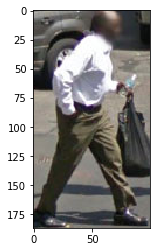

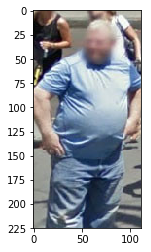

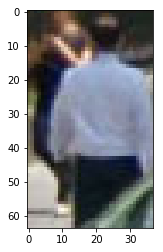

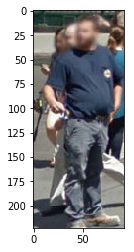

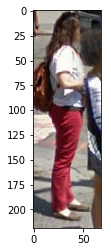

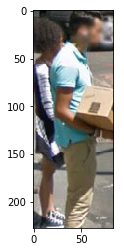

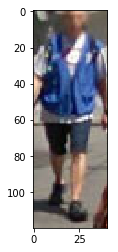

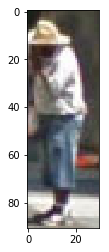

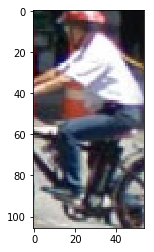

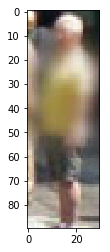

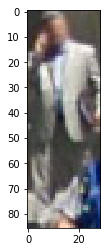

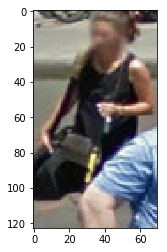

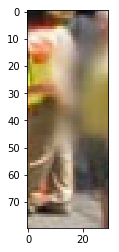

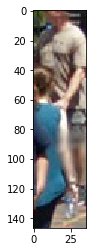

In [102]:
count = 0
thresh = 0.7
max_boxes = 30
centers = []
with tf.Session() as sess:
    for i, c in enumerate(classes):
        if (c == 1 and scores[i] > thresh and count < max_boxes):

            im_height = image_np.shape[0]
            im_width = image_np.shape[1]

            ymin, xmin, ymax, xmax = boxes[i]
            
            x_center, y_center = (xmin+xmax)/2, (ymin+ymax)/2
            centers.append(np.array((x_center, y_center)))
            
            (left, right, top, bottom) = (int(xmin*im_width),  int(xmax*im_width),
                                          int(ymin*im_height), int(ymax*im_height))

            (xmin, xmax, ymin, ymax) = (left, right, top, bottom)
            cropped_image = tf.image.crop_to_bounding_box(image_np, ymin, xmin, ymax-ymin, xmax-xmin)
            

            plt.imshow(np.array(sess.run(cropped_image), dtype=np.uint8))
            plt.show()
            count += 1

In [103]:
centers

[array([ 0.54970914,  0.71731883]),
 array([ 0.10559479,  0.81190062]),
 array([ 0.42348653,  0.51764721]),
 array([ 0.17879638,  0.75305629]),
 array([ 0.3783313 ,  0.79302812]),
 array([ 0.418176 ,  0.8170464]),
 array([ 0.34462547,  0.65281266]),
 array([ 0.81283134,  0.53129548]),
 array([ 0.92184705,  0.5922277 ]),
 array([ 0.78173661,  0.5340814 ]),
 array([ 0.33138791,  0.55310363]),
 array([ 0.07203902,  0.69956934]),
 array([ 0.7725383 ,  0.53404009]),
 array([ 0.21365817,  0.65821719])]

In [104]:
np.sqrt((824-157.5)*(824-157.5) + (452.5-512.5)*(452.5-512.5))

669.19522562552697

In [105]:
centers[1]-centers[0]

array([-0.44411435,  0.09458178])

In [107]:
np.linalg.norm(centers[0]-centers[1])

0.45407407911452569

In [106]:
np.linalg.norm(centers[4]-centers[5])

0.046523946554200557

In [108]:
np.linalg.norm(centers[7]-centers[9])

0.031219282245656354

In [109]:
np.linalg.norm(centers[1]-centers[3])

0.093920858190189041